In [ ]:
!pip install torch torchvision librosa qiskit-machine-learning scikit-learn qiskit qiskit-aer qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Deep learning/Dataset_v1/')

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to load images from CSV
def load_images_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {csv_file}"):
        img_path = row['spectrogram_path']
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            images.append(image)
            # If a label column exists, store the label; otherwise, append None.
            labels.append(row.get('label', None))
        else:
            print(f"Image not found: {img_path}")
    return images, labels

# Example usage:
train_csv = "train_spectrogram_tracking.csv"
valid_csv = "valid_spectrogram_tracking.csv"

train_images, train_labels = load_images_from_csv(train_csv)
valid_images, valid_labels = load_images_from_csv(valid_csv)

print(f"Loaded {len(train_images)} training images and {len(valid_images)} validation images.")

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

def preprocess_images(images):
    return torch.stack([transform(img) for img in images])

train_images_preprocessed = preprocess_images(train_images)
valid_images_preprocessed = preprocess_images(valid_images)

Processing valid_spectrogram_tracking.csv: 100%|██████████| 123/123 [00:44<00:00,  2.73it/s]


Loaded 556 training images and 123 validation images.


In [ ]:
# Load pre-trained SqueezeNet model and modify it to remove the final classification layer
squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.classifier = torch.nn.Identity()
squeezenet.eval()

def extract_features(images):
    with torch.no_grad():
        features = squeezenet(images)
    return features.numpy().reshape(images.shape[0], -1)

train_features = extract_features(train_images_preprocessed)
valid_features = extract_features(valid_images_preprocessed)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 50.0MB/s]


In [ ]:
# Combine features and labels
X_train = train_features
y_train = np.array(train_labels)
X_valid = valid_features
y_valid = np.array(valid_labels)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from qiskit_aer import AerSimulator

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms.classifiers import QSVC

# -----------------------
# Utility Functions
# -----------------------

def load_images_from_csv(csv_file):
    """
    Load images from a CSV file containing paths to spectrogram images and labels.
    """
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {csv_file}"):
        img_path = row['spectrogram_path']
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            images.append(image)
            # If a label column exists, store the label; otherwise, append None.
            labels.append(row.get('label', None))
        else:
            print(f"Image not found: {img_path}")
    return images, labels

def transform_image(image):
    """
    Transform the image into a format suitable for SqueezeNet.
    Converts the image to a tensor and resizes it to (224, 224).
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),          # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ])
    return transform(image)

# -----------------------
# SqueezeNet Model Setup
# -----------------------

# Load pre-trained SqueezeNet (using SqueezeNet 1.1) and set to evaluation mode.
squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.eval()  # Ensure the model is in evaluation mode.

# -----------------------
# Custom Dataset Class
# -----------------------

class SpectrogramDataset(Dataset):
    """
    Custom dataset for loading spectrogram images and labels from a CSV file.
    The CSV should have at least two columns: 'spectrogram_path' and 'label'.
    For this example, we assume label 'dementia' is mapped to 1, and all others to 0.
    """
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['spectrogram_path']
        label = 1 if row['label'] == 'dementia' else 0

        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform_image(image)
            with torch.no_grad():
                # Extract features using SqueezeNet's feature extractor
                features = squeezenet.features(image_tensor.unsqueeze(0))
            # Flatten the features to create a 1D vector
            feature_vector = features.view(-1).numpy()
            return feature_vector, label
        else:
            raise FileNotFoundError(f"Image file not found: {img_path}")

# -----------------------
# Feature Extraction & Preparation
# -----------------------

def extract_features_from_dataset(csv_file, max_samples=None):
    """
    Extract features from a dataset using the SpectrogramDataset class.
    Returns arrays of feature vectors and labels.
    If max_samples is specified, only that many samples are extracted.
    """
    dataset = SpectrogramDataset(csv_file)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    features_list = []
    labels_list = []
    for i, (features, label) in enumerate(tqdm(loader, total=len(dataset), desc=f"Extracting features from {csv_file}")):
        features_list.append(features.numpy().squeeze())
        labels_list.append(label.item())
        if max_samples is not None and i + 1 >= max_samples:
            break
    X = np.array(features_list)
    y = np.array(labels_list)
    return X, y

# -----------------------
# Quantum SVM Pipeline
# -----------------------

def run_qsvm_pipeline(train_csv, valid_csv, max_train_samples=None, max_valid_samples=None):
    # 1. Extract features from training and validation datasets
    print("Extracting training features...")
    X_train, y_train = extract_features_from_dataset(train_csv, max_samples=max_train_samples)

    print("Extracting validation features...")
    X_valid, y_valid = extract_features_from_dataset(valid_csv, max_samples=max_valid_samples)

    # 2. Dimensionality Reduction with PCA on training features
    # Quantum kernels work best on low-dimensional data (here reduced to 2 dimensions)
    pca = PCA(n_components=2)
    X_train_reduced = pca.fit_transform(X_train)
    X_valid_reduced = pca.transform(X_valid)

    # 3. Build the quantum feature map using a custom rotational layer + ZZFeatureMap
    feature_dimension = 2  # Should match the PCA reduced dimension
    reps = 2
    entanglement = 'linear'

    # Create a parameter vector for the custom rotational layer (here, one parameter)
    training_params = ParameterVector("θ", 1)

    # Custom rotational layer: apply an Ry gate on each qubit using the same parameter
    fm0 = QuantumCircuit(feature_dimension)
    for qubit in range(feature_dimension):
        fm0.ry(training_params[0], qubit)

    # Create the ZZFeatureMap
    fm1 = ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement=entanglement)

    # Compose the custom layer with the ZZFeatureMap
    feature_map = fm0.compose(fm1)

    # 4. Set up the quantum kernel using TrainableFidelityQuantumKernel
    # Instantiate a Sampler primitive (requires qiskit-primitives)
    sampler = Sampler()

    # Create a fidelity estimator using ComputeUncompute with the sampler
    fidelity = ComputeUncompute(sampler=sampler)

    # Instantiate the trainable quantum kernel.
    quantum_kernel = TrainableFidelityQuantumKernel(
        fidelity=fidelity,
        feature_map=feature_map,
        training_parameters=training_params
    )

    # Bind the training parameter (assign a numerical value)
    quantum_kernel.assign_training_parameters([np.pi / 2])

    # 5. Optimize the kernel parameters using QuantumKernelTrainer
    spsa_opt = SPSA(maxiter=10, learning_rate=0.01, perturbation=0.05)
    qkt = QuantumKernelTrainer(
        quantum_kernel=quantum_kernel,
        loss="svc_loss",
        optimizer=spsa_opt,
        initial_point=[np.pi / 2]
    )
    result = qkt.fit(X_train_reduced, y_train)
    quantum_kernel = result.quantum_kernel

    # 6. Initialize and train the quantum SVM (QSVC) classifier
    qsvc = QSVC(quantum_kernel=quantum_kernel)

    print("Training the QSVC model...")
    qsvc.fit(X_train_reduced, y_train)

    # 7. Evaluate on the validation set
    accuracy = qsvc.score(X_valid_reduced, y_valid)
    print("Validation Accuracy of the Quantum SVM:", accuracy)

    return qsvc, pca, X_valid, y_valid

# Example usage:
train_csv = "train_spectrogram_tracking.csv"
valid_csv = "valid_spectrogram_tracking.csv"

qsvc_model, pca_model, X_valid, y_valid = run_qsvm_pipeline(train_csv, valid_csv)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting training features...


Extracting features from train_spectrogram_tracking.csv: 100%|██████████| 556/556 [00:23<00:00, 23.18it/s]


Extracting validation features...


Extracting features from valid_spectrogram_tracking.csv: 100%|██████████| 123/123 [00:05<00:00, 20.79it/s]
<ipython-input-8-e188760dcdd2>:161: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Training the QSVC model...
Validation Accuracy of the Quantum SVM: 0.5121951219512195


Validation Accuracy: 0.5121951219512195
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.66      0.61        70
           1       0.41      0.32      0.36        53

    accuracy                           0.51       123
   macro avg       0.49      0.49      0.48       123
weighted avg       0.50      0.51      0.50       123

Confusion Matrix:
 [[46 24]
 [36 17]]


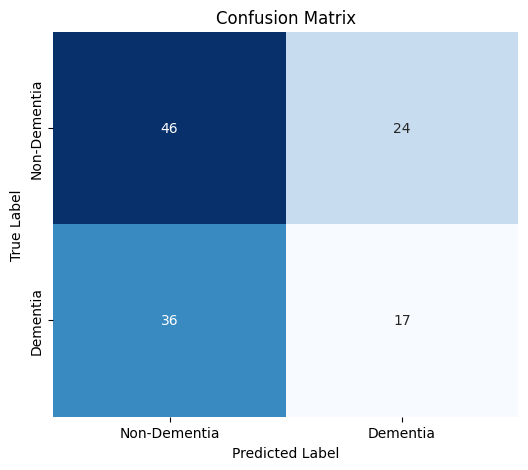

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(qsvc, pca, X_valid, y_valid):
    # Reduce the validation features
    X_valid_reduced = pca.transform(X_valid)

    # Predict labels using the trained QSVC model
    y_pred = qsvc.predict(X_valid_reduced)

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    print("Validation Accuracy:", accuracy)

    # Print classification report
    report = classification_report(y_valid, y_pred)
    print("Classification Report:\n", report)

    # Compute confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Dementia', 'Dementia'],
                yticklabels=['Non-Dementia', 'Dementia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(qsvc_model, pca_model, X_valid, y_valid)